# This code will train the model and save weights  using a data generator

First Import libraries

In [1]:
import os
import numpy as np
import keras
import tensorflow
from sklearn.model_selection import train_test_split
import nibabel as nib
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
from keras_unet.metrics import dice_coef
from keras_unet.models import custom_unet
from keras_unet.losses import jaccard_distance
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import ImageOps
import fnmatch
import nibabel as nib
import shutil

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
from tensorflow.python.client import device_lib
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Define our Data Generator and other functions to be used later

In [3]:
def gather_set(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(f)
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

In [4]:
def gather_set_and_path(data_path, phrase):
    set_of = []
    path = data_path + '\\'
    for f in os.listdir(data_path):
      if phrase in f:
        set_of.append(str(data_path+f))
      else:
        continue
    #set_of = np.array(set_of)

    indices = np.array(range(len(set_of))) # we will use this in the next step.

    return set_of

Define the paths where images and segmentations are located. Gather into groups and arrange into a dictionary that can be split up for training, testing, and validation for the model

## Expected Dimmentions

Image: (512,512) range: 0:255

Label: (512,512) range: 0:1

In [5]:
data_path_1 = r"C:\Users\UAB\data\KU\data\\"
data_path_2 = r"C:\Users\UAB\data\Mayo\data\\"
data_path_3 = r"C:\Users\UAB\data\Emory\data\\"
data_path_4 = r"C:\Users\UAB\data\UAB\data\\"

images_1 = gather_set_and_path(data_path_1, '_M')
images_2 = gather_set_and_path(data_path_2, '_M')
images_3 = gather_set_and_path(data_path_3, '_M')
images_4 = gather_set_and_path(data_path_4, '_M')


images = images_1+images_2+images_3+images_4


print(len(images))



77885


In [6]:
print(len(images_1))
print(len(images_2))
print(len(images_3))
print(len(images_4))


26082
21037
23488
7278


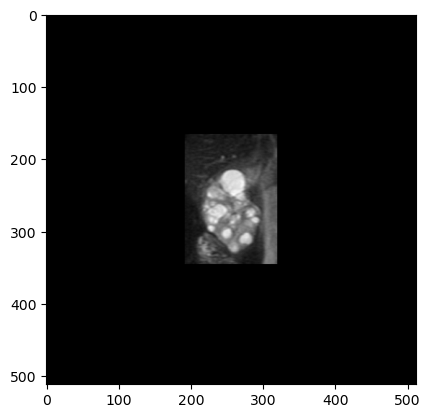

In [7]:
%matplotlib inline

image = np.load(images[-150])
plt.imshow(image, cmap='gray')

In [8]:
masks_1 = gather_set_and_path(data_path_1, '_K')
masks_2 = gather_set_and_path(data_path_2, '_K')
masks_3 = gather_set_and_path(data_path_3, '_K')
masks_4 = gather_set_and_path(data_path_4, '_K')

masks = masks_1 + masks_2 + masks_3 + masks_4

print(len(masks))

77885


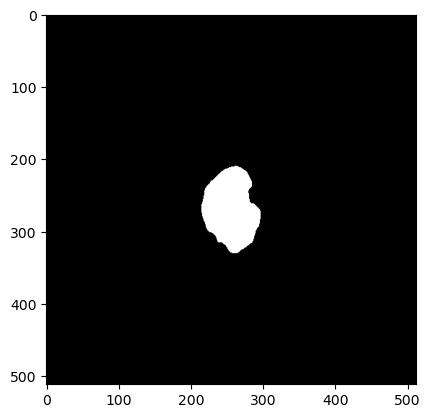

In [9]:
mask = np.load(masks[-150])
plt.imshow(mask, cmap='gray')

In [10]:

labels_1 = gather_set_and_path(data_path_1, '_C')
labels_2 = gather_set_and_path(data_path_2, '_C')
labels_3 = gather_set_and_path(data_path_3, '_C')
labels_4 = gather_set_and_path(data_path_4, '_C')

labels = labels_1 + labels_2 + labels_3 + labels_4

print(len(labels))


78257


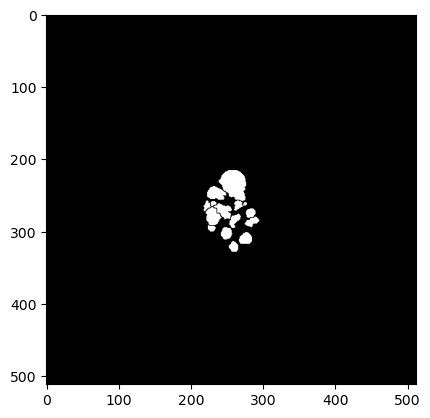

In [45]:
label = np.load(labels[-150])
plt.imshow(label, cmap='gray')

In [11]:
print(masks[-1500])
print(images[-1500])
print(labels[-1500])
test_img = np.load(images[100])
print(test_img.shape, test_img.max(), test_img.min())
test_msk = np.load(masks[100])
print(test_msk.shape, test_msk.max(), test_msk.min())
test_lab = np.load(labels[100])
print(test_lab.shape, test_lab.max(), test_lab.min())


C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_K.npy
C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_M.npy
C:\Users\UAB\data\UAB\data\\UB_479334_1_93_L_57_C.npy
(512, 512) 239 0
(512, 512) 1 0
(512, 512) 1 0


## Define Image and Label ID for data generator

Here the "test train split" will need to be replaced so we have the whole patient in one or the other"


In [47]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [48]:
print(len(labels))

77885


In [49]:
import os
img_name = os.path.basename(images[0])[0:11]
print(img_name)

KU_101934_0


Image separation for entire patient in training or validation - use with single set of images


In [50]:
from sklearn.model_selection import train_test_split


id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:11]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [51]:
print(len(unique_ids))

350


In [52]:
train, val = train_test_split(unique_ids, train_size = 0.8)

In [53]:
print(len(train))
print(len(val))

280
70


In [54]:
print(train[0:2])

['MA_323837_7', 'EM_271043_3']


In [55]:
#use this when images do not contain filepath:
#train_list = [image for image in images if image[0:8] in train]
#val_list = [image for image in images if image[0:8] in val] 

In [56]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train):
        train_list.append(images[i])

In [57]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val):
        val_list.append(images[i])

In [58]:
print(len(train_list))
print(len(val_list))
print(len(train_list)+len(val_list))
print(len(images))

62241
15644
77885
77885


In [59]:
partition = {'train':train_list, 'validation':val_list}

## Use for given csv file


In [12]:
import pandas as pd
df = pd.read_excel (r"C:\Users\UAB\Kidney-Segmentation-Jupyter\Data for AI development.xlsx", engine='openpyxl')

In [13]:
df = df.iloc[1: , 0:4]
df. columns=df. iloc[0] 

In [14]:
df2 = df.filter(regex='Validation')
df2 = df2.iloc[:,0].dropna()
val_csv_list = df2.values.tolist()
val_csv_list = val_csv_list[1:]

In [15]:
df3 = df.filter(regex='Training')
df3 = df3.iloc[:,0].dropna()
train_csv_list = df3.values.tolist()
train_csv_list = train_csv_list[1:]

In [16]:
print(len(train_csv_list))
print(train_csv_list[0])
print(len(val_csv_list))
print(val_csv_list[0])

151
439240L
19
419258L


In [17]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [18]:
id_list = []   
for i in range(len(images)):
    image_name = os.path.basename(images[i])
    unique_id =  image_name[0:17]
    id_list.append(unique_id)

unique_ids = list(set(id_list))

In [19]:
train_sets=[]
for i in range(len(train_csv_list)):
    phrase1 = train_csv_list[i][:-2]
    phrase2 = train_csv_list[i][-1]
    #print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                train_sets.append(name)
            else:
                continue
        else:
            continue

43924 L
43924 R
41412 L
41412 R
46492 L
47933 L
47933 R
49232 L
49232 R
40713 L
40713 R
45628 L
45628 R
24411 L
24411 R
20092 L
20092 R
20187 L
20187 R
21345 L
21345 R
24483 L
24483 R
24788 L
24788 R
27104 L
27104 R
27146 L
27146 R
20828 L
20828 R
20928 L
20928 R
21437 L
21437 R
22363 L
22363 R
23575 L
23575 R
24150 L
24150 R
24271 L
24271 R
24356 L
24356 R
24599 L
24599 R
24662 L
24662 R
24871 L
24871 R
25617 L
25617 R
26361 L
26361 R
26434 L
30064 L
30064 R
30137 L
30137 R
30386 L
30386 R
31231 L
31231 R
31330 L
31330 R
31389 L
31389 R
31611 L
31611 R
31856 L
31856 R
32095 L
32095 R
32383 L
32383 R
32705 L
32705 R
32732 L
32732 R
32793 L
32793 R
33684 L
33684 R
34323 L
34323 R
35930 L
35930 R
36466 L
36466 R
37102 L
37102 R
37468 L
10500 L
10050 L
10050 R
10079 L
10079 R
10193 L
10193 R
10500 R
11008 L
11008 R
11089 L
11089 R
11239 L
11239 R
11399 R
11904 L
11904 R
12039 L
12039 R
12077 L
12077 R
12080 L
12080 R
12495 L
12495 R
12859 L
12859 R
13605 L
13605 R
13948 L
14035 L
14035 R


In [20]:
val_sets=[]
for i in range(len(val_csv_list)):
    phrase1 = val_csv_list[i][:-2]
    phrase2 = val_csv_list[i][-1]
    print(phrase1, phrase2)
    for z in range(len(unique_ids)):
        name = unique_ids[z]
        if phrase1 in name:
            if phrase2 in name:
                val_sets.append(name)
            else:
                continue
        else:
            continue

41925 L
41925 R
26434 R
26517 L
26517 R
27168 L
27168 R
28393 L
37468 R
37625 L
37625 R
38016 L
17079 L
17079 R
17320 L
17320 R
17875 L
17875 R
18341 L


In [21]:
train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [22]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])

In [23]:
print(len(train_list))
print(len(val_list))

60327
8516


In [24]:
partition = {'train':train_list, 'validation':val_list}

## Use for crossfold validation:

In [27]:
d = {}
for i in images:
    if i not in d:
        d[i] = len(d)

labels_mapping = list(map(d.get, images))
#print(labels_mapping)

labels = {images[i]:labels_mapping[i] for i in range(len(images))}

In [28]:
train_sets = ['MA_', 'KU_', "EM_"]
val_sets = ["UB_"]

train_list = []
for i in range(len(images)):
    if any(phrase in images[i] for phrase in train_sets):
        train_list.append(images[i])


In [29]:
print(train_list[100])

C:\Users\UAB\data\Emory\data\\EM_200922_0_144_L_60_M.npy


In [30]:
val_list = [] 
for i in range(len(images)):
    if any(phrase in images[i] for phrase in val_sets):
        val_list.append(images[i])


In [31]:
print(val_list[100])

C:\Users\UAB\data\UAB\data\\UB_407132_0_95_R_14_M.npy


In [32]:
partition = {'train':train_list, 'validation':val_list}
print(len(train_list))
print(len(val_list))

23488
7278


# Create our data generators 

In [25]:
from Data_Gen_Cyst import DataGeneratorCyst
from Data_Gen_Mask import DataGeneratorK
from Data_Gen import DataGenerator 

In [35]:
#params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [26]:
params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 2,
          'shuffle': True}
training_generator = DataGeneratorK(partition['train'], labels, **params)
validation_generator = DataGeneratorK(partition['validation'], labels, **params)

In [28]:
#params = {'dim': (512,512),
          'batch_size': 32,
          'n_classes': 2,
          'n_channels': 1,
          'shuffle': True}
training_generator = DataGeneratorCyst(partition['train'], labels, **params)
validation_generator = DataGeneratorCyst(partition['validation'], labels, **params)

In [27]:
X, y = training_generator[8]
print(X.shape, y.shape)

(32, 512, 512, 2) (32, 512, 512, 2)


## View output

(512, 512) 73.0 0.0
(512, 512) 1.0 0.0


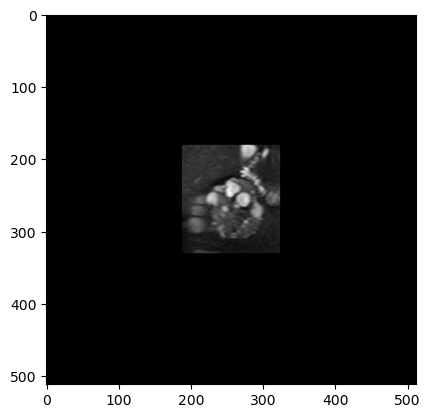

In [31]:
n=5
X_img = X[n,:,:,0]
X_msk =X[n,:,:,1] 
print(X_img.shape, X_img.max(), X_img.min())
print(X_msk.shape, X_msk.max(), X_msk.min())

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_img, cmap="gray")

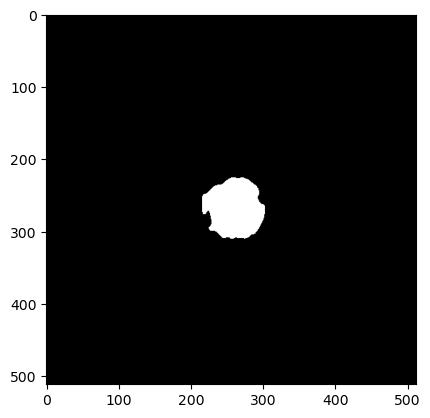

In [32]:
%matplotlib inline
plt.imshow(X_msk, cmap="gray")

(512, 512) 1.0 0.0


<Figure size 640x480 with 0 Axes>

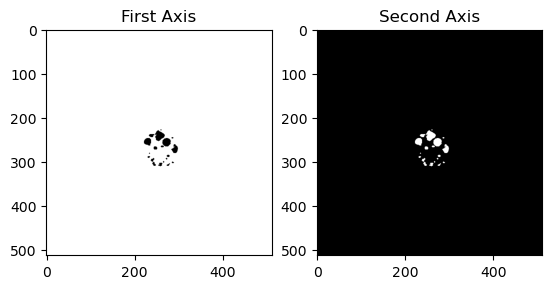

In [33]:
y_batch = y[n,:,:,:]
y_batch.shape
y_img_0 = y_batch[:,:,0]
y_img_1 = y_batch[:,:,1]
print(y_img_0.shape, y_img_0.max(), y_img_0.min())


plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(y_img_0, cmap="gray")
axarr[0].title.set_text('First Axis')
axarr[1].imshow(y_img_1, cmap='gray')
axarr[1].title.set_text('Second Axis')

In [36]:
model = custom_unet(input_shape=(512,512,2), num_classes=2)
#model.summary()

In [37]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [38]:
# define the checkpoint
from keras.callbacks import ModelCheckpoint
model_name = "cyst_seg_80-10_split_35epoch.h5"
filepath = model_name
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
cb = TimingCallback()

In [40]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=jaccard_distance,
  metrics=[dice_coef])

In [41]:
# Train model on dataset
history = model.fit(training_generator, epochs = 35,
                    validation_data = validation_generator,
                    use_multiprocessing=False,
                    workers=6, batch_size = 32,callbacks=[cb])

Epoch 1/35
1885/1885 [==============================] - 805s 422ms/step - loss: 0.1985 - dice_coef: 0.8997 - val_loss: 0.0119 - val_dice_coef: 0.9940
Epoch 2/35
1885/1885 [==============================] - 813s 430ms/step - loss: 0.0172 - dice_coef: 0.9913 - val_loss: 0.0047 - val_dice_coef: 0.9976
Epoch 3/35
1885/1885 [==============================] - 812s 430ms/step - loss: 0.0051 - dice_coef: 0.9974 - val_loss: 0.0030 - val_dice_coef: 0.9985
Epoch 4/35
1885/1885 [==============================] - 813s 431ms/step - loss: 0.0031 - dice_coef: 0.9984 - val_loss: 0.0025 - val_dice_coef: 0.9987
Epoch 5/35
1885/1885 [==============================] - 816s 432ms/step - loss: 0.0025 - dice_coef: 0.9988 - val_loss: 0.0025 - val_dice_coef: 0.9987
Epoch 6/35
1885/1885 [==============================] - 815s 432ms/step - loss: 0.0021 - dice_coef: 0.9989 - val_loss: 0.0018 - val_dice_coef: 0.9991
Epoch 7/35
1885/1885 [==============================] - 815s 432ms/step - loss: 0.0020 - dice_coef: 

In [43]:
print(cb.logs)
print(sum(cb.logs))

[804.7809971000001, 812.5080435999998, 812.0793399000004, 812.8167991999999, 816.4806128, 814.7407389999998, 814.9282776999999, 814.3259251999998, 814.6627620999989, 813.8581008000001, 819.9108938999998, 815.855631299999, 814.4974401, 813.9722870000005, 814.4037504000007, 813.8446809999987, 813.5246514999999, 813.2353351000002, 813.1935650999985, 812.9497697000006, 812.4593376000012, 812.7194353000014, 811.875259299999, 814.2756926000002, 813.8408973999976, 814.558520300001, 813.9582144999986, 812.6809251000013, 812.6301542999972, 812.621837900002, 813.2607401999994, 814.1240159000008, 812.3608970999994, 811.7946454000012, 814.1640334000003]
28473.894208799997


In [45]:
sum(cb.logs)/3600

7.909415057999999

In [46]:
time = list(cb.logs)
print(time)

[804.7809971000001, 812.5080435999998, 812.0793399000004, 812.8167991999999, 816.4806128, 814.7407389999998, 814.9282776999999, 814.3259251999998, 814.6627620999989, 813.8581008000001, 819.9108938999998, 815.855631299999, 814.4974401, 813.9722870000005, 814.4037504000007, 813.8446809999987, 813.5246514999999, 813.2353351000002, 813.1935650999985, 812.9497697000006, 812.4593376000012, 812.7194353000014, 811.875259299999, 814.2756926000002, 813.8408973999976, 814.558520300001, 813.9582144999986, 812.6809251000013, 812.6301542999972, 812.621837900002, 813.2607401999994, 814.1240159000008, 812.3608970999994, 811.7946454000012, 814.1640334000003]


In [47]:
import pandas as pd
df = pd.DataFrame.from_dict(history.history)

In [48]:
df['epoch_time'] = np.array(cb.logs)

In [49]:
df.to_csv('cyst_seg_80-10_split_35epoch.csv')

In [50]:
import pandas as pd

DF = pd.read_csv('cyst_seg_80-10_split_35epoch.csv')

print(DF) 

    Unnamed: 0      loss  dice_coef  val_loss  val_dice_coef  epoch_time
0            0  0.198545   0.899746  0.011866       0.993960  804.780997
1            1  0.017190   0.991275  0.004750       0.997579  812.508044
2            2  0.005099   0.997405  0.003020       0.998461  812.079340
3            3  0.003108   0.998417  0.002451       0.998749  812.816799
4            4  0.002451   0.998750  0.002450       0.998749  816.480613
5            5  0.002149   0.998904  0.001847       0.999057  814.740739
6            6  0.001958   0.999002  0.001838       0.999062  814.928278
7            7  0.001843   0.999058  1.447078       0.202280  814.325925
8            8  0.001716   0.999124  0.001625       0.999170  814.662762
9            9  0.001641   0.999162  0.001598       0.999185  813.858101
10          10  0.001581   0.999194  0.001673       0.999147  819.910894
11          11  0.001531   0.999220  0.001623       0.999172  815.855631
12          12  0.001475   0.999248  0.001812      

In [51]:
from keras.models import Sequential, load_model
model.save(model_name)    

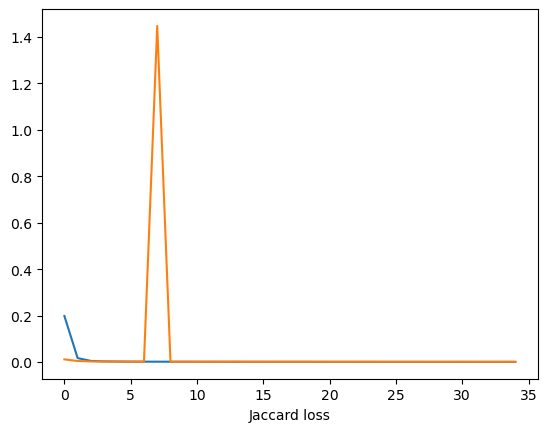

In [52]:
%matplotlib inline
plt.plot(range(len(history.history['loss'])), history.history['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

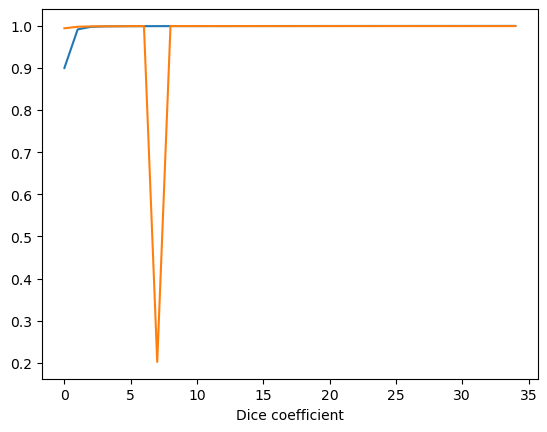

In [53]:
plt.plot(range(len(history.history['dice_coef'])), history.history['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(history.history['val_dice_coef'])), history.history['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')

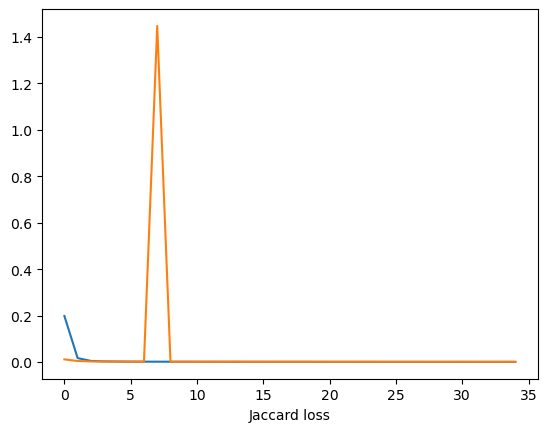

In [54]:
%matplotlib inline
plt.plot(range(len(DF['loss'])), DF['loss'], '-') #TODO: plot the training loss learning curve
plt.plot(range(len(DF['val_loss'])), DF['val_loss'], '-') #TODO: plot the validation loss learning curve
plt.xlabel('epoch')
plt.xlabel('Jaccard loss')

plt.show()

Text(0.5, 0, 'Dice coefficient')

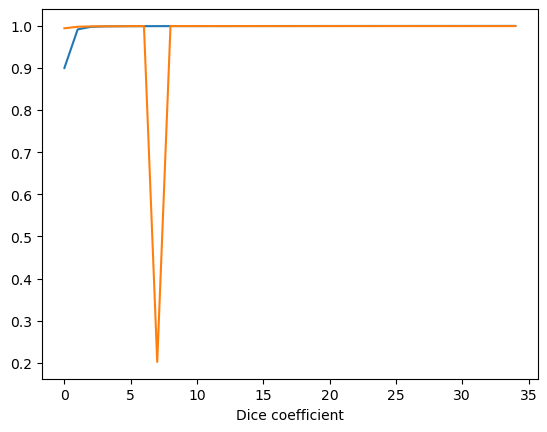

In [55]:
plt.plot(range(len(df['dice_coef'])), df['dice_coef'], '-') #TODO: plot the training dice_coef learning curve

plt.plot(range(len(df['val_dice_coef'])), df['val_dice_coef'], '-') #TODO: plot the validation dice_coef learning curve
plt.xlabel('epoch')
plt.xlabel('Dice coefficient')